In [45]:
# all this code was borrowed from 
# https://towardsdatascience.com/how-i-used-machine-learning-to-automatically-hand-draw-any-picture-7d024d0de997
import cv2;
from matplotlib import pyplot as plt
import numpy as np
import pyautogui as pg
import kdtree
import operator
from cnc import CNC
from sklearn.cluster import KMeans
from collections import defaultdict

class AutoDraw(object):
    def __init__(self, name, blur = 0):
        # Tunable parameters
        self.detail = 1
        self.scale = 7/12
        self.sketch_before = False
        self.with_color = True
        self.num_colors = 10
        self.outline_again = False

        # Load Image. Switch axes to match computer screen
        self.img = cv2.imread(name)
        self.blur = blur
        self.img = np.swapaxes(self.img, 0, 1)
        self.img_shape = self.img.shape

#         self.dim = pg.size()

        # 30 cm x 18 cm
        self.dim = (250, 150)

        # Scale to draw inside part of screen
        self.startX = ((1 - self.scale) / 2)*self.dim[0] 
        self.startY = ((1 - self.scale) / 2)*self.dim[1] 
        self.dim = (self.dim[0] * self.scale, self.dim[1] * self.scale)

        # fit the picture into this section of the screen
        if self.img_shape[1] > self.img_shape[0]:
            # if it's taller that it is wide, truncate the wide section
            self.dim = (int(self.dim[1] * (self.img_shape[0] / self.img_shape[1])), self.dim[1])
        else:
            # if it's wider than it is tall, truncate the tall section
            self.dim = (self.dim[0], int(self.dim[0] *(self.img_shape[1] / self.img_shape[0])))

        # Get dimension to translate picture. Dimension 1 and 0 are switched due to comp dimensions
        ratio = self.img.shape[0] / self.img.shape[1]
        pseudo_x = int(self.img.shape[1] * self.detail)
        self.pseudoDim = (pseudo_x, int(pseudo_x * ratio))
        
          # Initialize directions for momentum when creating path
        self.maps = {0: (1, 1), 1: (1, 0), 2: (1, -1), 3: (0, -1), 4: (0, 1), 5: (-1, -1), 6: (-1, 0), 7: (-1, 1)}
        self.momentum = 1
        self.curr_delta = self.maps[self.momentum]

        # Create Outline
        self.drawing = self.process_img(self.img)
        plt.imshow(self.drawing)
        plt.show()

    def rescale(self, img, dim):
        resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        return resized

    def translate(self, coord):
        ratio = (coord[0] / self.pseudoDim[1], coord[1] / self.pseudoDim[0]) # this is correct
        deltas = (int(ratio[0] * self.dim[0]), int(ratio[1] * self.dim[1]))
        return self.startX + deltas[0], self.startY + deltas[1]
    
    def process_img(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if self.blur == 2:
            gray = cv2.GaussianBlur(gray, (9, 9), 0)
            canny = cv2.Canny(gray, 25, 45)
        elif self.blur == 1:
            gray = cv2.GaussianBlur(gray, (3, 3), 0)
            canny = cv2.Canny(gray, 25, 45)
        else:  # no blur
            canny = cv2.Canny(gray, 50, 75)
        canny = self.rescale(canny, self.pseudoDim)
        r, res = cv2.threshold(canny, 50, 255, cv2.THRESH_BINARY_INV)

        return res
    
    def drawOutline(self):
        indices = np.argwhere(self.drawing < 127).tolist()  # get the black colors
        index_tuples = map(tuple, indices)

        self.hashSet = set(index_tuples)
        self.KDTree = kdtree.create(indices)
#         self.KDTree = KDTree(indices)
        self.commands = []
        self.curr_pos = (0, 0)
        point = self.translate(self.curr_pos)
        self.commands.append(point)

#         print('Please change pen to thin and color to black.')
#         input("Press enter once ready")
#         print('')

        # DRAW THE BLACK OUTLINE
        self.createPath()
#         self.cleanCommands()
        return self.commands
#         print(self.commands)
#         input("Ready! Press Enter to draw")
#         print('5 seconds until drawing beings')
#         time.sleep(5)

#         self.execute(self.commands)

    def createPath(self):
        # check for closest point. Go there. Add click down. Change curr. Remove from set and tree. Then, begin
        new_pos = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#         print(self.curr_pos[0)
#         new_pos = tuple(self.KDTree.query(self.curr_pos)[0].data)
        self.commands.append(new_pos)
        self.commands.append("DOWN")
        self.curr_pos = new_pos
        self.KDTree = self.KDTree.remove(list(new_pos))
        self.hashSet.remove(new_pos)

        while len(self.hashSet) > 0:
            prev_direction = self.momentum
            candidate = self.checkMomentum(self.curr_pos)
            if self.isValid(candidate):
                new = tuple(map(operator.add, self.curr_pos, candidate))
                new_pos = self.translate(new)
                if prev_direction == self.momentum and type(self.commands[-1]) != str:  # the direction didn't change
                    self.commands.pop()
                self.commands.append(new_pos)
            else:
                self.commands.append("UP")
                new = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#                 new = tuple(self.KDTree.query(self.curr_pos)[0].data)
                new_pos = self.translate(new)
                self.commands.append(new_pos)
                self.commands.append("DOWN")
            self.curr_pos = new
            self.KDTree = self.KDTree.remove(list(new))
            self.hashSet.remove(new)
#             print('Making path...number points left: ', len(self.hashSet))
        return

#     def cleanCommands(self):
#         self.commands = self.commands[2:]
#         for command in self.commands:
#             if(type(command) is not str):
#                 command[0] -= 25
#                 command[1] -=25

    def isValid(self, delta):
        return len(delta) == 2

    def checkMomentum(self, point):
        # Returns best next relative move w.r.t. momentum and if in hashset
        self.curr_delta = self.maps[self.momentum]
        moments = self.maps.values()
        deltas = [d for d in moments if (tuple(map(operator.add, point, d)) in self.hashSet)]
        deltas.sort(key=self.checkDirection, reverse=True)
        if len(deltas) > 0:
            best = deltas[0]
            self.momentum = [item[0] for item in self.maps.items() if item[1] == best][0]
            return best
        return [-1]

    def checkDirection(self, element):
        return self.dot(self.curr_delta, element)

    def dot(self, pt1, pt2):
        pt1 = self.unit(pt1)
        pt2 = self.unit(pt2)
        return pt1[0] * pt2[0] + pt1[1] * pt2[1]

    def unit(self, point):
        norm = (point[0] ** 2 + point[1] ** 2)
        norm = np.sqrt(norm)
        return point[0] / norm, point[1] / norm
    
    def draw(self):
        if self.with_color:
            color = self.rescale(self.img, self.pseudoDim)
            collapsed = np.sum(color, axis=2)/3
            fill = np.argwhere(collapsed < 230)  # color 2-d indices
            fill = np.swapaxes(fill, 0, 1)  # swap to index into color
            RGB = color[fill[0], fill[1], :]
            k_means = KMeans(n_clusters=self.num_colors).fit(RGB)
            colors = k_means.cluster_centers_
            labels = k_means.labels_
            fill = np.swapaxes(fill, 0, 1).tolist()  # swap back to make dictionary
            label_2_index = defaultdict(list)

            for i, j in zip(labels, fill):
                label_2_index[i].append(j)

            for (i, color) in enumerate(colors):
                # Grayscale conversion formula found at 
                # https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/
                grayscale = 0.299 * color[2] + 0.587 * color[1] + 0.114 * color[0]
#                 print(grayscale)
#                 print('Please change the pen to thick and color to BGR (not RGB) values: ', color)
#                 input("Press enter once ready")
#                 print('')

                points = label_2_index[i]
                index_tuples = map(tuple, points)
                self.hashSet = set(index_tuples)
                self.KDTree = kdtree.create(points)
                self.commands = []
                self.curr_pos = (0, 0)
                point = self.translate(self.curr_pos)
                self.commands.append(point)
                self.commands.append("UP")
                self.createPath()

#                 input('Ready! Press enter to draw: ')
#                 print('5 seconds until drawing begins...')
#                 time.sleep(5)
#                 self.execute(self.commands)
            return self.commands
            if self.outline_again:
                self.drawOutline()

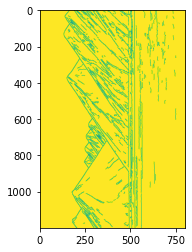

In [46]:
drawing = AutoDraw("./landscape.jpeg", blur=2)
commands = drawing.drawOutline()


In [47]:
print(commands)

[(52.08333333333333, 31.249999999999996), (32, 137), 'DOWN', (56.08333333333333, 47.25), (56.08333333333333, 48.25), (57.08333333333333, 48.25), (57.08333333333333, 48.25), (57.08333333333333, 48.25), (57.08333333333333, 48.25), (58.08333333333333, 48.25), (58.08333333333333, 48.25), (58.08333333333333, 48.25), (59.08333333333333, 49.25), (59.08333333333333, 49.25), (60.08333333333333, 49.25), (60.08333333333333, 49.25), (60.08333333333333, 50.25), (61.08333333333333, 50.25), (61.08333333333333, 50.25), (62.08333333333333, 50.25), (62.08333333333333, 49.25), (63.08333333333333, 49.25), (63.08333333333333, 48.25), (63.08333333333333, 48.25), (64.08333333333333, 48.25), (64.08333333333333, 48.25), (64.08333333333333, 48.25), (65.08333333333333, 48.25), (65.08333333333333, 47.25), (65.08333333333333, 47.25), (65.08333333333333, 47.25), (65.08333333333333, 47.25), (66.08333333333333, 47.25), (66.08333333333333, 47.25), (66.08333333333333, 47.25), (66.08333333333333, 47.25), (66.08333333333

In [53]:
cnc = CNC()
cnc.open("./test.gcode")

# cnc.render_text_file(open("./test.txt", "r"), 5)
cnc.g90()
cnc.g0(z=5)
cnc.f(3000)
cnc.g0(z=5)
# cnc.g1(z=0)
prevNonUpOrDownCommand = (0, 0)
newCommands = [] 
for index in range(len(commands)):
    if(prevNonUpOrDownCommand == commands[index]):
        continue
    if commands[index] == 'UP':
        if commands[index + 1] != 'UP' and commands[index + 1] != 'DOWN':
            newCommands.append(commands[index])
#             cnc.up()
    elif commands[index] == 'DOWN':
        if commands[index + 1] != 'UP' and commands[index + 1] != 'DOWN':
            newCommands.append(commands[index])
#             cnc.down()
    else:
#         cnc.g1(x=commands[index][1] - 15,y=-commands[index][0] + 15)
        newCommands.append(commands[index])
        prevNonUpOrDownCommand = commands[index]

for index in range(len(newCommands)):
    if newCommands[index] == 'UP':
        if newCommands[index + 1] != 'UP' and newCommands[index + 1] != 'DOWN':
#             newCommands.append(commands[index])
            cnc.up()
    elif newCommands[index] == 'DOWN':
        if newCommands[index + 1] != 'UP' and newCommands[index + 1] != 'DOWN':
#             newCommands.append(commands[index])
            cnc.down()
    else:
        cnc.g1(x=newCommands[index][1] - 15,y=-newCommands[index][0] + 45)
#         newCommands.append(commands[index])
#         prevNonUpOrDownCommand = commands[index]

cnc.close()

G90 
G0 Z5
F3000
G0 Z5
G1 X16.249999999999996 Y-7.083333333333329
G1 X122 Y13
G1 Z0
G1 X32.25 Y-11.083333333333329
G1 X33.25 Y-11.083333333333329
G1 X33.25 Y-12.083333333333329
G1 X33.25 Y-13.083333333333329
G1 X34.25 Y-14.083333333333329
G1 X34.25 Y-15.083333333333329
G1 X35.25 Y-15.083333333333329
G1 X35.25 Y-16.08333333333333
G1 X35.25 Y-17.08333333333333
G1 X34.25 Y-17.08333333333333
G1 X34.25 Y-18.08333333333333
G1 X33.25 Y-18.08333333333333
G1 X33.25 Y-19.08333333333333
G1 X33.25 Y-20.08333333333333
G1 X32.25 Y-20.08333333333333
G1 X32.25 Y-21.08333333333333
G1 X32.25 Y-22.08333333333333
G1 X31.25 Y-22.08333333333333
G1 X31.25 Y-23.08333333333333
G1 X32.25 Y-24.08333333333333
G1 X32.25 Y-25.08333333333333
G1 X33.25 Y-26.08333333333333
G1 X33.25 Y-27.08333333333333
G1 X34.25 Y-27.08333333333333
G1 X35.25 Y-28.08333333333333
G1 X35.25 Y-29.08333333333333
G1 X36.25 Y-29.08333333333333
G1 X36.25 Y-30.08333333333333
G1 X37.25 Y-31.08333333333333
G1 X37.25 Y-32.08333333333333
G1 X38.25

G1 X91.25 Y-110.08333333333331
G1 X91.25 Y-109.08333333333331
G1 X91.25 Y-108.08333333333331
G0 Z1
G1 X92.25 Y-114.08333333333331
G1 Z0
G1 X92.25 Y-115.08333333333331
G1 X92.25 Y-116.08333333333331
G1 X92.25 Y-117.08333333333331
G1 X91.25 Y-117.08333333333331
G1 X92.25 Y-117.08333333333331
G1 X91.25 Y-117.08333333333331
G1 X92.25 Y-117.08333333333331
G1 X92.25 Y-118.08333333333331
G1 X92.25 Y-119.08333333333331
G1 X92.25 Y-120.08333333333331
G1 X92.25 Y-121.08333333333331
G1 X92.25 Y-122.08333333333331
G1 X91.25 Y-122.08333333333331
G1 X92.25 Y-122.08333333333331
G1 X92.25 Y-123.08333333333331
G0 Z1
G1 X92.25 Y-120.08333333333331
G1 Z0
G1 X92.25 Y-117.08333333333331
G1 X92.25 Y-116.08333333333331
G0 Z1
G1 X89.25 Y-121.08333333333331
G1 Z0
G1 X89.25 Y-122.08333333333331
G1 X89.25 Y-123.08333333333331
G1 X89.25 Y-124.08333333333331
G1 X89.25 Y-125.08333333333331
G0 Z1
G1 X83.25 Y-105.08333333333331
G0 Z1
G1 X83.25 Y-99.08333333333331
G1 Z0
G1 X83.25 Y-98.08333333333331
G0 Z1
G1 X83.25 Y-

G0 Z1
G1 X49.25 Y-19.08333333333333
G0 Z1
G1 X48.25 Y-19.08333333333333
G1 Z0
G1 X48.25 Y-18.08333333333333
G1 Z0
G1 X47.25 Y-17.08333333333333
G1 X46.25 Y-17.08333333333333
G1 X47.25 Y-17.08333333333333
G1 X47.25 Y-16.08333333333333
G1 X46.25 Y-16.08333333333333
G1 X44.25 Y-14.083333333333329
G1 X43.25 Y-13.083333333333329
G1 X42.25 Y-12.083333333333329
G1 X41.25 Y-11.083333333333329
G1 X40.25 Y-10.083333333333329
G1 X40.25 Y-9.083333333333329
G1 X40.25 Y-8.083333333333329
G1 X39.25 Y-8.083333333333329
G1 X39.25 Y-7.083333333333329
G1 X38.25 Y-7.083333333333329
G1 X39.25 Y-7.083333333333329
G0 Z1
G1 X39.25 Y-8.083333333333329
G0 Z1
G1 X40.25 Y-9.083333333333329
G0 Z1
G1 X40.25 Y-10.083333333333329
G0 Z1
G1 X41.25 Y-10.083333333333329
G0 Z1
G1 X41.25 Y-11.083333333333329
G0 Z1
G1 X42.25 Y-11.083333333333329
G1 Z0
G1 X42.25 Y-12.083333333333329
G0 Z1
G1 X43.25 Y-12.083333333333329
G0 Z1
G1 X43.25 Y-13.083333333333329
G0 Z1
G1 X44.25 Y-14.083333333333329
G0 Z1
G1 X44.25 Y-15.083333333333

G1 X92.25 Y-8.083333333333329
G1 Z0
G1 X92.25 Y-9.083333333333329
G1 X92.25 Y-10.083333333333329
G1 Z0
G1 X92.25 Y-11.083333333333329
G1 X92.25 Y-12.083333333333329
G0 Z1
G1 X92.25 Y-13.083333333333329
G0 Z1
G1 X93.25 Y-14.083333333333329
G0 Z1
G1 X93.25 Y-15.083333333333329
G1 Z0
G1 X93.25 Y-16.08333333333333
G1 X93.25 Y-17.08333333333333
G1 X93.25 Y-18.08333333333333
G1 X94.25 Y-18.08333333333333
G1 X93.25 Y-18.08333333333333
G1 Z0
G1 X93.25 Y-19.08333333333333
G1 X93.25 Y-20.08333333333333
G1 X93.25 Y-21.08333333333333
G1 X93.25 Y-22.08333333333333
G1 X94.25 Y-23.08333333333333
G1 X93.25 Y-23.08333333333333
G1 X93.25 Y-24.08333333333333
G1 X93.25 Y-25.08333333333333
G1 X93.25 Y-26.08333333333333
G1 X93.25 Y-27.08333333333333
G1 X93.25 Y-28.08333333333333
G1 X93.25 Y-29.08333333333333
G1 X93.25 Y-30.08333333333333
G1 X94.25 Y-30.08333333333333
G1 Z0
G1 X94.25 Y-29.08333333333333
G1 X94.25 Y-28.08333333333333
G1 Z0
G1 X95.25 Y-28.08333333333333
G1 X94.25 Y-29.08333333333333
G1 X95.25 

IndexError: list index out of range

In [ ]:
drawing.draw()